<a href="https://colab.research.google.com/github/preetbhagat7/LovePreet-Portfolio/blob/main/classification_searches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers torch

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import re
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Searches.xlsx to Searches.xlsx


In [4]:
df = pd.read_excel("Searches.xlsx")

# Clean query column
df['query'] = df['query'].astype(str).str.strip()

In [5]:
# Define category list
categories = [
"Apparel & Lifestyle",
"Home, Kitchen & Living",
"Health, Fitness & Wellness",
"Baby, Kids & Parenting",
"Consumer Electronics",
"Hardware & DIY Tools",
"Sports, Travel & Recreation",
"Beauty, Grooming & Personal Care",
"Automobile Parts & Accessories",
"Food, Grocery & Beverages",
"Pet Care & Supplies",
"Office & Learning Essentials"
]

In [6]:
# Zero-shot classifier
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0  # GPU if available
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [7]:
# Convert column to list
queries = df['query'].tolist()

In [8]:
# Batch classification
results = classifier(
    sequences=queries,
    candidate_labels=categories,
    hypothesis_template="This item is related to {}."
)

In [9]:
# Append results
df['predicted_category'] = [r['labels'][0] for r in results]
df['pred_score'] = [round(r['scores'][0], 3) for r in results]

In [10]:
# Count categories
category_counts = df['predicted_category'].value_counts()

print("Category Count Summary:")
print(category_counts)


Category Count Summary:
predicted_category
Health, Fitness & Wellness          305
Consumer Electronics                287
Home, Kitchen & Living              204
Sports, Travel & Recreation         128
Baby, Kids & Parenting              101
Food, Grocery & Beverages            75
Automobile Parts & Accessories       27
Pet Care & Supplies                  26
Beauty, Grooming & Personal Care     25
Hardware & DIY Tools                 16
Apparel & Lifestyle                  13
Office & Learning Essentials          1
Name: count, dtype: int64


In [11]:
# Convert category counts to dict for lookup
category_totals = category_counts.to_dict()

# PIE CHART
# def show_pie_chart():
#     plt.figure(figsize=(5, 5))
#     plt.pie(category_totals.values(), labels=category_totals.keys(), autopct='%1.1f%%')
#     plt.title("Search Distribution by Category")
#     plt.show()
def show_pie_chart():
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(8, 8))

    # Generate distinct colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(category_totals)))

    wedges, texts = plt.pie(
        category_totals.values(),
        startangle=140,
        colors=colors
    )

    # Add legend with category names + percentage
    percentages = [
        f"{cat} — {val / sum(category_totals.values()) * 100:.1f}%"
        for cat, val in category_totals.items()
    ]

    plt.legend(
        wedges,
        percentages,              # Percentage appears in box
        title="Categories & Share",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=True,             # Draw box
        shadow=True,              # Professional effect
        borderpad=1
    )

    plt.title("Search Distribution by Category", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


def show_bar_chart():
    import matplotlib.pyplot as plt

    # Sort categories by count ascending (small → large)
    sorted_categories = dict(sorted(category_totals.items(), key=lambda x: x[1]))

    plt.figure(figsize=(12, 7))

    bars = plt.bar(
        sorted_categories.keys(),
        sorted_categories.values(),
    )

    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f"{height:,}",  # 1,200 format
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

    plt.xticks(rotation=45, ha='right')
    plt.title("Search Volume by Category (Smallest to Largest)", fontsize=14, fontweight='bold')
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Search Count", fontsize=12)
    plt.tight_layout()
    plt.show()







# LOOKUP FUNCTION
def lookup_keyword():
    user_kw = input("\nEnter keyword to search: ").strip().lower()
    pattern = rf"{re.escape(user_kw)}"   # partial match allowed

    # mask to filter searches
    mask = df['query'].str.contains(pattern, case=False, na=False)

    if mask.sum() == 0:
        print("\n This keyword has NEVER been searched before!\n")
        show_pie_chart()
        show_bar_chart()
        return

    matched_queries = df.loc[mask, 'query'].str.lower().tolist()
    query_counter = Counter(matched_queries)

    print("\n============================")
    print(f"🔍 Keyword: {user_kw}")
    print("============================")
    print(f"Total Searches Matching This Keyword: {sum(query_counter.values())}\n")

    print("Matched Queries:")
    for q, c in query_counter.items():
        print(f"  {q} → {c}")

    # Detect predicted category
    found_cat = df.loc[df['query'].str.lower() == user_kw, 'predicted_category']
    found_cat = found_cat.values[0] if len(found_cat) > 0 else None

    if found_cat:
        cat_count = category_totals.get(found_cat, 0)

        # searches in this category for this keyword
        matched_in_category = df[(df['predicted_category'] == found_cat) &
                                 (df['query'].str.contains(pattern, case=False, na=False))].shape[0]

        print(f"\nPredicted Category: {found_cat}")
        print(f"Total Searches in this Category: {cat_count}")
        # print(f" Searches with this Keyword in this Category: {matched_in_category}")
    else:
        print("\n No category detected for this keyword.")

    print("\n CATEGORY SEARCH DISTRIBUTION")
    show_bar_chart()
    show_pie_chart()




## To Download Excel_file Uncomment Below:-

In [12]:
# Save classified results to Excel
output_file = "classified_search_results.xlsx"
df.to_excel(output_file, index=False)

print(f"File saved successfully: {output_file}")

from google.colab import files
files.download(output_file)


File saved successfully: classified_search_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Enter keyword to search: massager

🔍 Keyword: massager
Total Searches Matching This Keyword: 128

Matched Queries:
  massager foot → 10
  massager → 78
  head massager → 1
  massager calf leg → 2
  body massager → 1
  lifelong massager under 10000 → 1
  massager body → 2
  face massager → 1
  massager gun → 6
  tredmil with massager → 1
  warranty massager → 1
  massager thigh → 1
  massager pain relief → 2
  massager calf → 1
  lifelong massager under 5000 → 1
  leg & calf massager → 1
  massager foot calf → 1
  foot massager wire → 1
  lifelong massager foot → 1
  massager vibrator → 1
  massager air pressure → 1
  air massager → 1
  massager electric → 1
  massager leg → 1
  massager under 15000 → 1
  gun massager → 1
  electric foot massager → 1
  massager handheld → 1
  eye massager → 2
  arm massager → 1
  massager leg calf → 1
  cushion massager → 1
  lifelong massager gun → 1

Predicted Category: Consumer Electronics
Total Searches in this Category: 287

 CATEGORY SEARCH DISTR

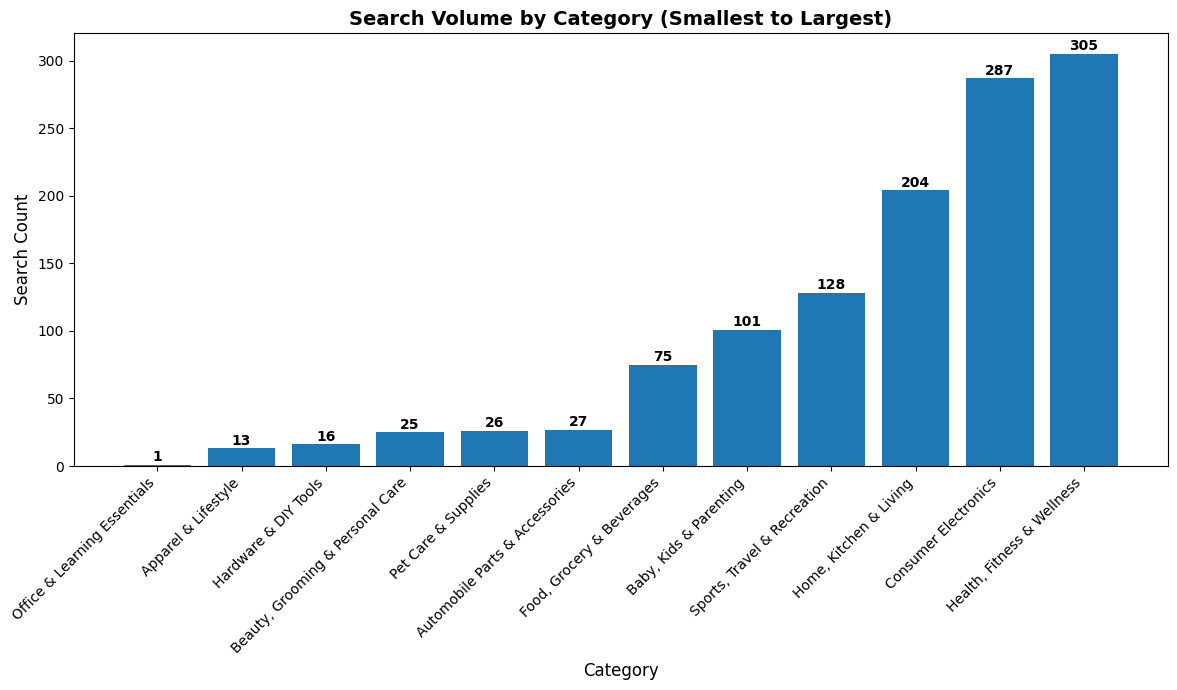

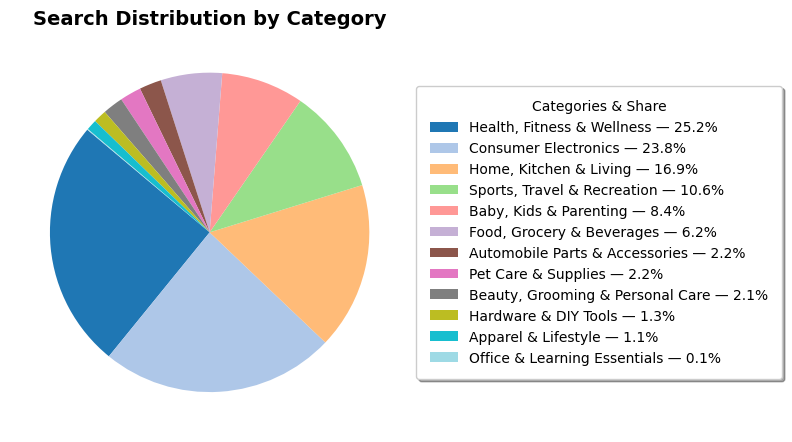

In [13]:
# RUN THE LOOKUP ANYTIME
lookup_keyword()
